# 1. Cleaning

Note: the existing "2008.csv" file in the directory could be the smaller version of the original.
Consider downloading full-size file from http://stat-computing.org/dataexpo/2009/2008.csv.bz2

In [2]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# import database
df = pd.read_csv('2008_1.csv')

<center>Table: (sample) Dataframe including column dtype</center>

In [3]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN
dtypes,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,int64,float64,float64,int64,object,int64,float64,float64,float64,float64,float64


## 1.1. Descriptive Statistics

<center>Figure: Correlation Matrix of some columns</center>

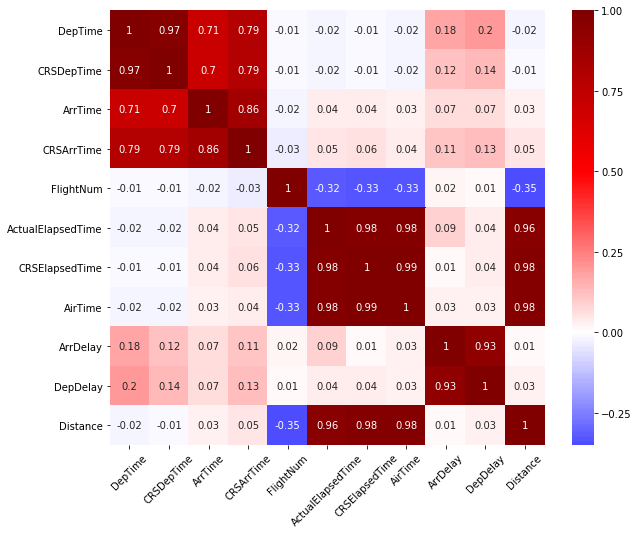

In [4]:
def plot_corr_matr(df, figsize=(10, 8)):
    """
    Plot Correlation matrix using Seaborns heatmap

    Parameters
    ----------
    df: pandas.DataFrame

    figsize: tuple
        size of the whole plot
    """
    plt.figure(figsize=figsize)
    corr = df.corr().round(2)
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    # Viet tat seaborn as sns
    sns.heatmap(
        corr,
        cmap="seismic",
        square=True,
        xticklabels=corr.columns.values,
        yticklabels=corr.columns.values,
        center=0,
        annot=True)
    plt.xticks(rotation=45)
    plt.show()
    
plot_corr_matr(df.loc[:,'DepTime':'Distance'])
# plot_corr_matr(df)

//////// _From the graph above, which features, in your opinions, should be removed, which should be kept, why?_

## 1st

-To classify whether a flight is late or not, choose __ArrTime as the label__.

-__ArrTime__, and __DepTime__ although have high correlation (0.72) but still not enough, we leave it to PCA to eliminate collinearity.

-__CRSArrTime__ and __ArrTime__ also has 0.87 correlation score, we just keep __ArrTime__ as it is the real time data.

-__ActualElapsedTime, CRSElapedTime, AirTime__ and __Distance__ have very high correlation (>0.95) so we can just keep one feature (Distance) as predictor.

-__CRSDepTime__ and __DepTime__ also has 0.97 correlation score, we just keep __DepTime__ as it is the real time data.

-__DepDelay__ is a predictor and __ArrDelay__ is a lable. __DepDelay__ and __ArrDelay__ have very high correlation (0.93).
So we want to see if other features can be a good predictors to ArrDelay, __delete DepDelay is the choice__.










In [5]:
# delete CRSDepTime, CRSArrTime, ActualElapsedTime, CRSElapsedTime, AirTime, DepDelay
del df['CRSDepTime']
del df['CRSArrTime']
del df['ActualElapsedTime']
del df['CRSElapsedTime']
del df['AirTime']
del df['DepDelay']

In [6]:
# Loc cac mau tin sau khi loai bo CRSDepTime, CRSArrTime, ActualElapsedTime, CRSElapsedTime, AirTime, DepDelay
df = df.loc[:,'DepTime':'Distance']

////////// End the 1st request

<center>Table: Describe database</center>

In [7]:
# Hien thi dac tinh
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DepTime,6.87348e+06,NaN,NaN,NaN,1333.83,478.069,1,928,1325,1728,2400
ArrTime,6.85808e+06,NaN,NaN,NaN,1481.26,505.225,1,1107,1512,1909,2400
UniqueCarrier,7009728,20,WN,1201754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FlightNum,7.00973e+06,NaN,NaN,NaN,2224.2,1961.72,1,622,1571,3518,9743
TailNum,6926363,5373,N476HA,4701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,6.85503e+06,NaN,NaN,NaN,8.16845,38.5019,-519,-10,-2,12,2461
Origin,7009728,303,ATL,414513,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,7009728,304,ATL,414521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,7.00973e+06,NaN,NaN,NaN,726.387,562.102,11,325,581,954,4962


## 1.2. NaN Cleaning

<center>Table: Recheck describe columns with NaN values</center>

In [8]:
from IPython.display import display
import pandas as pd
def desc_nan(df):
    """
    Show a table that describe about all columns of @df that contain NaN.
    Hien thi 1 bang mieu ta tat ca cac cot, bao gom ca NaN
    
    """
    row, col = df.shape #Get shape
    nas = row - df.describe(include='all').T['count']
    nas = nas[nas > 0]
    ps = nas / row * 100
    ms = df.mode().iloc[0]
    nadf = pd.DataFrame(data={
        'Na Count': nas,
        'Na Percentage': ps,
        'mode': ms
    }).loc[nas.index]
    dnadf = df.describe().T.reindex(nadf.index)
    nadf = pd.concat([nadf, dnadf.iloc[:, 1:]], axis=1) #Noi cac du lieu cau truc pandas
    display(nadf)

desc_nan(df)

,Na Count,Na Percentage,mode,mean,std,min,25%,50%,75%,max
DepTime,136246,1.94367,555,1333.830046,478.068895,1.0,928.0,1325.0,1728.0,2400.0
ArrTime,151649,2.16341,1020,1481.258227,505.225129,1.0,1107.0,1512.0,1909.0,2400.0
TailNum,83365,1.18928,N476HA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,154699,2.20692,-5,8.168452,38.501937,-519.0,-10.0,-2.0,12.0,2461.0


<center>Figure: Distribution plot of all numeric columns</center>

In [9]:
def plot_ft_dist(df, fig_height=4, no_of_col=2,verbose=True):
    """
    Plot distribution of all numeric columns in df (Phan phoi bieu do cua tat ca cac cot so)

    Parameters
    ----------
    df: pandas.DataFrame

    fig_height: int

    no_of_col: int
    """
    df = df.copy()
    # prepare df
    cat_cols = list(df.dtypes[df.dtypes == 'object'].index)
    if verbose: # Neu dai dong bo qua cac cot phan loai
        print("Ignored categorical columns: ", cat_cols)
        print("")
    df_hasnan = df.isna().any().any()
    if df_hasnan:# 
        nan_cols = list(df.loc[:,df.isna().any()].columns)
        df.dropna(inplace=True, axis=1)
        if verbose:
            print("dropped NaN cols:", str(nan_cols))
            print("")
    try:    
        desc = df.describe().T
        std0 = list(desc.loc[desc['std']==0].index)
        if verbose:
            print("dropped std=0 cols:", str(std0))
            print("")
        for col in std0:
            del df[col]
    except KeyError:
        pass
    
    idx = df.dtypes[df.dtypes != 'object'].index
    # prepare frame
    f, axes = plt.subplots(
        int(np.ceil(len(idx) / no_of_col)),
        no_of_col,
        figsize=(5 * no_of_col, np.ceil(len(idx) / no_of_col) * fig_height))
    sns.set(style="white", palette="muted", color_codes=True)
    n = 0
    for i in idx:
        sns.distplot(
            df[i],
            color='b',
            hist=True,
            kde_kws={"shade": True},
            ax=axes[n // no_of_col, n % no_of_col])
        n += 1
    plt.show()
    
#plot_ft_dist(df)

////// _Run codes above, describe what you see and start clean data / remove unimportant columns._

## 2nd 

In [10]:
desc_nan(df)

,Na Count,Na Percentage,mode,mean,std,min,25%,50%,75%,max
DepTime,136246,1.94367,555,1333.830046,478.068895,1.0,928.0,1325.0,1728.0,2400.0
ArrTime,151649,2.16341,1020,1481.258227,505.225129,1.0,1107.0,1512.0,1909.0,2400.0
TailNum,83365,1.18928,N476HA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,154699,2.20692,-5,8.168452,38.501937,-519.0,-10.0,-2.0,12.0,2461.0


In [11]:
# drop rows where DepTime or ArrTime is na
df.drop(df[df.DepTime.isna()].index, inplace = True)
df.drop(df[df.ArrTime.isna()].index, inplace = True)
df.drop(df[df.TailNum.isna()].index, inplace = True)
df.drop(df[df.ArrDelay.isna()].index, inplace = True)

Ignored categorical columns:  ['UniqueCarrier', 'TailNum', 'Origin', 'Dest']

dropped std=0 cols: []



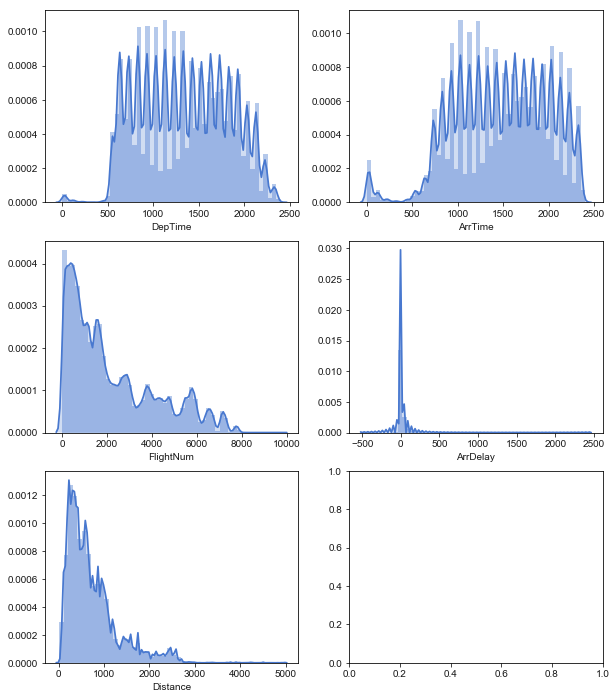

In [12]:
plot_ft_dist(df)

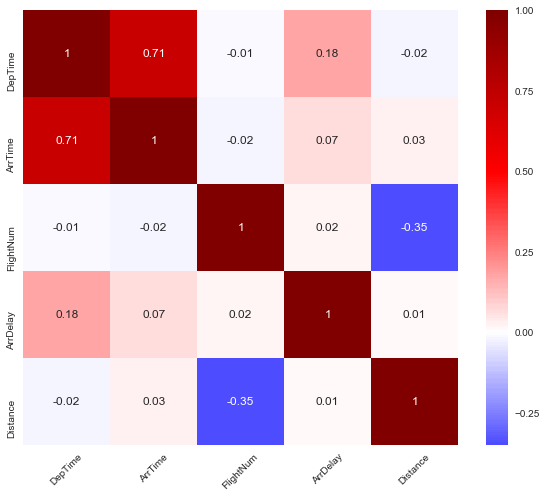

In [13]:
plot_corr_matr(df)

////////// End the 2nd request

<center>Table: (sample) Database after cleaning</center>

In [14]:
df.head(2)

,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,Distance
0,2003.0,2211.0,WN,335,N712SW,-14.0,IAD,TPA,810
1,754.0,1002.0,WN,3231,N772SW,2.0,IAD,TPA,810


## 1.3. Feature Engineering

/////////// Give some insights, split train-test dataset




### 1.3.1 Data Transformation

__DepTime, ArrTime__ are time values which if being stored in 10-based (decimal), their true values will be distorted (hours:minutes is not continuous on 10-based).
#=> convert to minute integer

In [15]:
# convert column to min:
def to_min(n):
    n = str(int(n))
    if len(n)<=2:
        return int(n)
    else:
        return int(n[:-2])*60+int(n[2:])
df.DepTime=df.DepTime.apply(to_min)
df.ArrTime=df.ArrTime.apply(to_min)

Convert all float dtype columns to int64 dtype

In [16]:
for col in df.columns:
    if df[col].dtype == np.float:
        df[col] = df[col].astype(np.int64)

<center>Table: (sample) Dataframe after dtype convertion</center>

In [17]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,Distance
0,1203,1331,WN,335,N712SW,-14,IAD,TPA,810
1,424,602,WN,3231,N772SW,2,IAD,TPA,810
dtypes,int64,int64,object,int64,object,int64,object,object,int64


### 1.3.2. One-hot-encoding

In order to pick which feature to use One-hot-encoding, we see how many unique data in each category data, then use boxplot to check the variation of ArrDelay by those features.
<br><br>
<center>Table: Unique value from each categorial feature</center>

In [18]:
pd.DataFrame(df.describe(include="O").loc['unique']).T

,UniqueCarrier,TailNum,Origin,Dest
unique,20,5366,303,302


/////// _start your code below to one hot encode or label encoding categorical features_

## 3rd




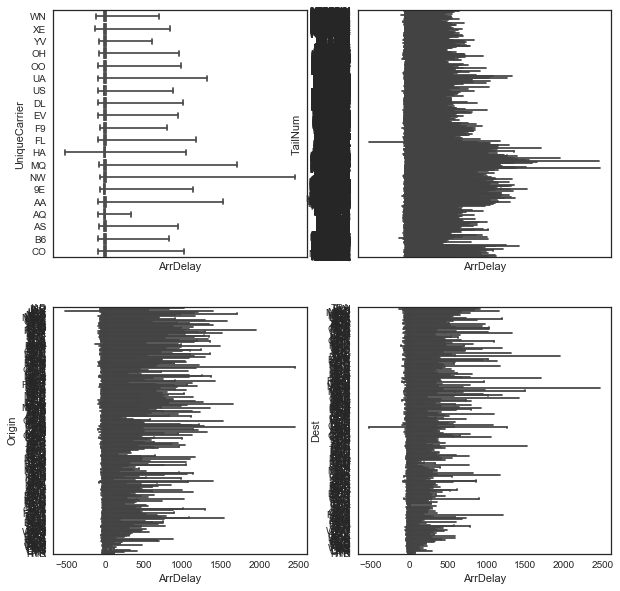

In [19]:
sns.set(style="white")
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,sharex=True, squeeze=True, 
                                figsize=(10,10))

sns.boxplot(x="ArrDelay", y="UniqueCarrier", data=df,
            whis=np.inf, palette="vlag",ax=ax1)

sns.boxplot(x="ArrDelay", y="TailNum", data=df,
            whis=np.inf, palette="vlag",ax=ax2)

sns.boxplot(x="ArrDelay", y="Origin", data=df,
            whis=np.inf, palette="vlag",ax=ax3)

sns.boxplot(x="ArrDelay", y="Dest", data=df,
            whis=np.inf, palette="vlag", ax=ax4)
plt.show()

We assume that each __TailNum__ belongs to 1 __UniqueCarrier__. How late a flight is seems to more dependent on __UniqueCarrier__ than the __TailNum__. But we need to check this hypothesis by showing if there is any __TailNum__ that is NOT operated by 1 __UniqueCarrier__.
<br><br>
<center>Table: TailNum that is not operated by one UniqueCarrie</center>

In [20]:
# Check if there is any TailNum that belongs to 2 UniqueCarriers
pd.DataFrame(df.groupby('TailNum').UniqueCarrier.unique()
                [df.groupby('TailNum').UniqueCarrier.unique()
                     .apply(lambda x: len(x)!=1)])

,UniqueCarrier
TailNum,
N376CA,"[OH, EV]"
N379CA,"[OH, EV]"


The table rejects our hypothesis, but it shows only 2 instances of __TailNum__.
The total number of records of N376CA and N379CA is 3171/6855024 (0.0462%) which is a very small affect (if any) on the prediction result. In addition, the amount of unique __TailNum__ is too large (5366) that might result in not having enough samples for each unique __TailNum__ (which makes the result more unreliable)

__Origin__ or __Dest__ can be reliable predictors but currently we skip these rows for computational benefits.

After finish analyzing those 4 categorial features, only 1 column to one-hot-encode is __UniqueCarrier__.

In [21]:
# one-hot-encode UniqueCarrier column
carrier = pd.get_dummies(df.UniqueCarrier)
carrier.reset_index(drop=True, inplace=True)

////////// End the 3rd request

## 2.2. Normalize data

/////// _normalize / scale your data to range [0,1]

## 4th



Because of feature scaling, new table of normalized data (in range [0,1]) is needed.

Do tính năng chia tỷ lệ, cần có bảng dữ liệu chuẩn hóa mới (trong phạm vi [0,1]).

In [22]:
# delete categorical data:
for col in df.columns:
    if df[col].dtype == np.object:
        del df[col]

# Normalize the df
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(df)
X = pd.DataFrame(X, columns=df.columns)

In [23]:
# combine normalized data with one-hot-encoded columns
X = X.join(carrier)

In [24]:
# assign ArrDelay in format of boolean, True if ArrDelay > 30 minutes
Y = df.ArrDelay>30
Y.reset_index(drop=True, inplace=True)
del df['ArrDelay']

////////// End the 4th request

<center>Table: (sample) Predictor X (without PCA)

In [25]:
X[:2]

,DepTime,ArrTime,FlightNum,ArrDelay,Distance,9E,AA,AQ,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV
0,0.835302,0.924253,0.034292,0.169463,0.161382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.293954,0.417651,0.331622,0.174832,0.161382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## 2.3. PCA

<center>Figure: Explaination ratio though dimensions using PCA and Cumulative explained variance table in details</center>

Hình: Tỷ lệ giải thích, mặc dù kích thước sử dụng PCA và bảng phương sai giải thích tích lũy chi tiết

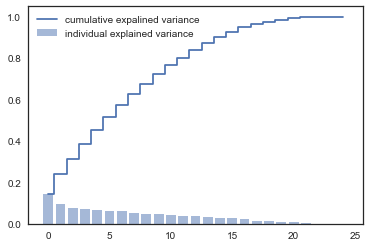

,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,dim 10,dim 11,dim 12,dim 13,dim 14,dim 15,dim 16,dim 17,dim 18,dim 19,dim 20,dim 21,dim 22,dim 23,dim 24,dim 25
0,0.14552,0.239712,0.314865,0.386304,0.453326,0.514254,0.574592,0.628011,0.677201,0.722456,0.764904,0.801996,0.83824,0.872379,0.900631,0.928427,0.949974,0.96393,0.975674,0.985319,0.993911,0.998743,0.999851,1.0,1.0


In [26]:
def plot_PCA(df):
    """
    Show the "PCA ladder" in order to pick the right

    Parameters
    ----------
    df: pandas.DataFrame

    fig_height: int

    no_of_col: int
    """
    from sklearn.decomposition import PCA

    pca = PCA(n_components=len(df.columns))
    pca.fit_transform(df)
    # put data (predictor only) to pca and create pcadf
    ratio = pca.explained_variance_ratio_

    tot = sum(ratio)
    var_exp = [(i / tot) for i in ratio]
    cum_var_exp = np.cumsum(var_exp)

    plt.bar(
        range(0, len(df.columns)),
        var_exp,
        alpha=0.5,
        align='center',
        label='individual explained variance') #phuong sai giai thich ca nhan/ doc lap
    plt.step(
        range(0, len(df.columns)),
        cum_var_exp,
        where='mid',
        label='cumulative expalined variance') #phương sai tích lũy
    plt.ylabel = 'Explained variance ratio'
    plt.xlabel = 'Pricipal components'
    plt.legend(loc='best')
    plt.show()

    # show table with more details
    pdf = pd.DataFrame(
        [cum_var_exp],
        columns=["dim {}".format(i) for i in range(1,
                                                   len(df.columns) + 1)])
    display(pdf)
    
    
plot_PCA(X)

//////////// the code below has "n" as dimensions to reduce to, decide that number so the total explation ratio > 0.95

## 5th




In [27]:
from sklearn.decomposition import PCA
# create a PCA to reduce dimension to n
n = 18
pca = PCA(n_components=n)
# put data (predictor only) to pca and create pcadf
X = pd.DataFrame(pca.fit_transform(X))

In [28]:
# get random 100_000 samples records from full dataset to tune
x_tune = X.sample(n=100000, random_state=25)
y_tune = Y.sample(n=100000, random_state=25)

# get random 1_250_000 samples records from full dataset
# that differ from the x_100k and y_100k
x = (X[~X.index.isin(x_tune.index)]
        .sample(n=1250000, random_state=25))
y = (Y[~Y.index.isin(x_tune.index)]
        .sample(n=1250000, random_state=25))

In [29]:
# prepare the train and test data.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                        x, y, test_size=0.2, random_state=25)

//////// End the 5th request

In [30]:
# Save processed database to a csv file
import os
os.chdir(r'.\working_database')

x_tune.to_csv('x_tune.csv')
pd.DataFrame(y_tune).to_csv('y_tune.csv')
x_train.to_csv('x_train.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
x_test.to_csv('x_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

os.chdir('..')

# 3. Classification Models

In [31]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# Load processed database from a csv file
import os
os.chdir(r'.\working_database')

x_tune = pd.read_csv('x_tune.csv', index_col=0)
y_tune = pd.read_csv('y_tune.csv', index_col=0)
x_train = pd.read_csv('x_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
x_test = pd.read_csv('x_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

os.chdir('..')

The following model will use default parameters and sample classification report

## 3.1. Naive Bayes

Initialize the model and fit the train database

In [32]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB(priors=None)

In [33]:
from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=nb.predict(x_test)))

Classification_report: 
              precision    recall  f1-score   support

      False       0.87      0.95      0.91    217000
       True       0.16      0.07      0.10     33000

avg / total       0.78      0.83      0.80    250000



////// Search google for "sklearn logistics regression" / decision tree / svm and figure out how to work on below parts

## 6th



## 3.2. Logistics Regression

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', # 'l1'
                        C = 1.0) # float

In [35]:
from sklearn.model_selection import GridSearchCV
# Defind the parameter values that should be searched
C_list = [0.1, 1, 10, 100, 1000]
penalty_list = ['l1','l2']
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(C=C_list,
                 penalty=penalty_list,
                 solver=solver_list)
# Instantiate the grid:
grid = GridSearchCV(lr, param_grid, cv=10, error_score=0.0,
                    scoring='f1_weighted', n_jobs=16)

# fit the grid with data
grid.fit(x_tune, y_tune)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.806592470771
{'C': 0.1, 'solver': 'liblinear', 'penalty': 'l1'}


,rank_test_score,mean_fit_time,mean_test_score,param_C,param_solver,param_penalty
2,1,0.778179,0.806592,0.1,liblinear,l1
28,1,5.959486,0.806592,10,sag,l2
29,1,4.033685,0.806592,10,saga,l2
32,1,0.648117,0.806592,100,liblinear,l1
34,1,4.696540,0.806592,100,saga,l1
35,1,8.301590,0.806592,100,newton-cg,l2
36,1,1.957485,0.806592,100,lbfgs,l2
27,1,0.934353,0.806592,10,liblinear,l2
37,1,0.714893,0.806592,100,liblinear,l2
39,1,2.809642,0.806592,100,saga,l2


In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.1,
                        penalty='l1',
                        solver='liblinear')
lr.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=lr.predict(x_test)))

Classification_report: 
              precision    recall  f1-score   support

      False       0.87      1.00      0.93    217000
       True       0.00      0.00      0.00     33000

avg / total       0.75      0.87      0.81    250000



## 3.3. Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', # 'entropy'
                             min_samples_leaf=1, # float
                             class_weight=None # 'balance'
                             ) 
# tree.fit(x_train, y_train)

In [38]:
from sklearn.model_selection import GridSearchCV
# Defind the parameter values that should be searched
criterion_list = ['gini','entropy']
min_samples_leaf_list = [1,2,4,6,8,10]
class_weight_list = [None,'balanced']
# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(criterion=criterion_list,
                 min_samples_leaf=min_samples_leaf_list,
                 class_weight=class_weight_list)

# Instantiate the grid:
grid = GridSearchCV(tree, param_grid, cv=10, 
                    scoring='f1_weighted', n_jobs=16)

# fit the grid with data
grid.fit(x_tune, y_tune)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.829939263052
{'class_weight': None, 'min_samples_leaf': 10, 'criterion': 'gini'}


,rank_test_score,mean_fit_time,mean_test_score,param_class_weight,param_min_samples_leaf,param_criterion
5,1,10.088222,0.829939,None,10,gini
11,2,14.336375,0.829290,None,10,entropy
1,3,10.069973,0.829021,None,2,gini
4,4,9.912056,0.828854,None,8,gini
2,5,10.685705,0.827286,None,4,gini
10,6,13.801959,0.827263,None,8,entropy
7,7,18.322433,0.826899,None,2,entropy
3,8,10.120909,0.826610,None,6,gini
12,9,9.185932,0.826122,balanced,1,gini
6,10,16.780549,0.825786,None,1,entropy


In [39]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_leaf=2,
                              class_weight=None)
                              
tree.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=nb.predict(x_test)))

Classification_report: 
              precision    recall  f1-score   support

      False       0.87      0.95      0.91    217000
       True       0.16      0.07      0.10     33000

avg / total       0.78      0.83      0.80    250000



## 3.4. SVM

In [40]:
from sklearn.svm import SVC
svm = SVC(C = 1.0,       # float
         kernel = 'rbf', # 'linear','poly', 'sigmoid'
         gamma = 'auto') # float
# svm.fit(x_train, y_train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Defind the parameter values that should be searched
C_list = [1,10,100,1000]
kernel_list = ['rbf','linear','poly','sigmoid']
gamma_list = ['auto', 10, 0.2]
# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(C=C_list,
                  kernel=kernel_list,
                  gamma=gamma_list)

# Instantiate the rand:
rand = RandomizedSearchCV(svm, param_grid, cv=5, 
                         scoring='f1_weighted', n_jobs=16,
                         n_iter=5, random_state=25)

# fit the rand with data
rand.fit(x_tune, y_tune)

# examine the best model
print(rand.best_score_)
print(rand.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(rand.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in rand.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')               
svm.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=svm.predict(x_test)))

////////// End the 6th request

# Z. Other
Additional parts

## Z.1. Pickle

In [ ]:
# Save a model into a pickle file.
import pickle
import os
os.chdir(r'.\saved_models')
pickle.dump(svm, open( "svm.model", "wb" ) )
os.chdir('..')

In [ ]:
# Load the model back from the pickle file.
import pickle
import os
os.chdir(r'.\saved_models')
lr = pickle.load(open("lr.model", "rb"))
nb = pickle.load(open("nb.model", "rb"))
rf = pickle.load(open("rf.model", "rb"))
tree = pickle.load(open("tree.model", "rb"))
svm = pickle.load(open("svm.model", "rb"))
os.chdir('..')